In [1]:

from langchain import  PromptTemplate



/tmp/ipykernel_594/3622290940.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
from dotenv import load_dotenv


os.environ["OPENAI_API_TYPE"] = OPENAI_API_TYPE
os.environ["OPENAI_API_VERSION"] = OPENAI_API_VERSION
os.environ["OPENAI_API_BASE"] = OPENAI_API_BASE
os.environ["AZURE_OPENAI_ENDPOINT"] = OPENAI_API_BASE
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["OPENAI_DEPLOYMENT_NAME"] = OPENAI_DEPLOYMENT_NAME

load_dotenv()

False

In [6]:

from langchain.chat_models import AzureChatOpenAI
from langchain.schema import HumanMessage

In [8]:
# Test the model connection
model = AzureChatOpenAI(
    openai_api_version=OPENAI_API_VERSION,
    deployment_name=OPENAI_DEPLOYMENT_NAME,
)
  

/home/vscode/.local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.azure_openai.AzureChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import AzureChatOpenAI`.
  warn_deprecated(


In [9]:
message = HumanMessage(
    content="Translate this sentence from English to French. I love programming."
)
model([message])



/home/vscode/.local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


AIMessage(content="J'aime la programmation.")

In [10]:
from langchain.document_loaders import PyPDFLoader
# Load the book
loader = PyPDFLoader("/workspaces/info-assist/docs/Into-Thin-Air-_Novella_-Krakauer.pdf")
pages = loader.load()

# Cut out the open and closing parts
# pages = pages[0:36]

# Combine the pages, and replace the tabs with spaces
text = ""

for page in pages:
    text += page.page_content
    
text = text.replace('\t', ' ')

In [11]:
num_tokens=model.get_num_tokens(text)
num_tokens

126727

In [12]:
# Loaders
from langchain.schema import Document

# Splitters
from langchain.text_splitter import RecursiveCharacterTextSplitter


# Embedding Support

from langchain.embeddings import AzureOpenAIEmbeddings

# LLM Part :Summarizer is Map Reduce
from langchain.chains.summarize import load_summarize_chain

# Data Science part
import numpy as np
from sklearn.cluster import KMeans

In [13]:
text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", "\t"], chunk_size=10000, chunk_overlap=3000)

docs = text_splitter.create_documents([text])

In [14]:
num_documents = len(docs)

print (f"Now our book is split up into {num_documents} documents")

Now our book is split up into 73 documents


In [15]:

embeddings = AzureOpenAIEmbeddings(
    azure_deployment="text-embedding-ada-002",
    openai_api_version="2023-06-01-preview",
)

/home/vscode/.local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.azure_openai.AzureOpenAIEmbeddings` was deprecated in langchain-community 0.1.0 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import AzureOpenAIEmbeddings`.
  warn_deprecated(


In [16]:

vectors = embeddings.embed_documents([x.page_content for x in docs])

In [18]:
from sklearn.manifold import TSNE

import warnings
from warnings import simplefilter

# Filter out FutureWarnings
simplefilter(action='ignore', category=FutureWarning)

# Perform t-SNE and reduce from 1536 dimension to 2 dimensions
tsne = TSNE(n_components=2, random_state=12)

vectors = np.array(vectors)
reduced_data_tsne = tsne.fit_transform(vectors)

In [92]:
#Clustering on reduced dimentional data

In [19]:
num_clusters = 5

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(reduced_data_tsne)

In [20]:
kmeans.labels_

array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 3, 2, 3, 2,
       2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 3, 4, 4, 3, 3, 0, 0,
       1, 3, 4, 4, 4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 1, 1, 1, 0, 0, 1], dtype=int32)

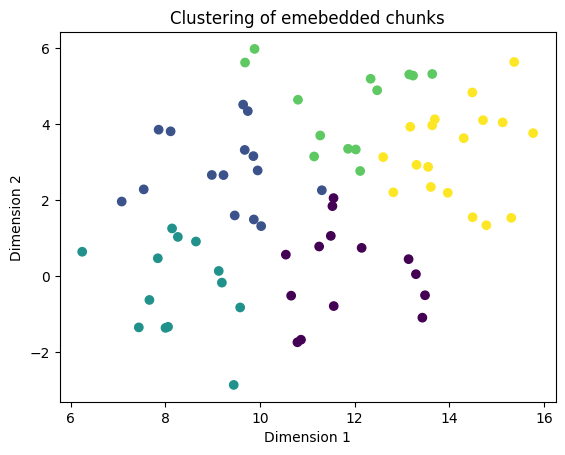

In [22]:
# Plot the reduced data
import matplotlib.pyplot as plt
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Clustering of emebedded chunks')
plt.show()

In [27]:
# Create DataFrame from reduced dimentions and cluster labels
df = pd.DataFrame({
    'Dimension 1': reduced_data_tsne[:, 0],
    'Dimension 2': reduced_data_tsne[:, 1],
    'Cluster': kmeans.labels_
})

In [ ]:
#find the most representative vector from each cluster

In [59]:
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

# Calculate centroids for each cluster
centroids = []
closest_member_indices = []
for cluster_label in np.unique(df['Cluster']):
    cluster_points = df[df['Cluster'] == cluster_label][['Dimension 1', 'Dimension 2']]
    centroid = cluster_points.mean()
    centroids.append((centroid, cluster_label))  # Store centroid and cluster label

# Create a scatter plot for the data points
scatter = px.scatter(df, x='Dimension 1', y='Dimension 2', color='Cluster', opacity=0.7, title='Best Representation Vectors ')

# Add centroids and closest members to the scatter plot
for i, (centroid, cluster_label) in enumerate(centroids):
    cluster_color = px.colors.qualitative.Plotly[cluster_label]  # Get cluster color
    
    # Find the index of the closest member to the centroid
    closest_member_idx = df[df['Cluster'] == cluster_label][['Dimension 1', 'Dimension 2']].apply(lambda x: np.linalg.norm(x - centroid), axis=1).idxmin()
    closest_member_indices.append(closest_member_idx)
    closest_member = df.loc[closest_member_idx]
    
    # Plot closest member
    scatter.add_trace(go.Scatter(x=[closest_member['Dimension 1']], y=[closest_member['Dimension 2']], mode='markers', marker=dict(color=cluster_color, symbol='star', size=11), name=f'Cluster {cluster_label} Closest Member'))

    # Plot centroid
    scatter.add_trace(go.Scatter(x=[centroid[0]], y=[centroid[1]], mode='markers', marker=dict(color=cluster_color, symbol='x', size=12), name=f'Cluster {cluster_label} Centroid'))
    
     # Plot cluster members
    cluster_members = df[df['Cluster'] == cluster_label][['Dimension 1', 'Dimension 2']]
    scatter.add_trace(go.Scatter(x=cluster_members['Dimension 1'], y=cluster_members['Dimension 2'], mode='markers', marker=dict(color=cluster_color, symbol='circle', size=8), name=f'Cluster {cluster_label} Members'))

# Hide the color bar
scatter.update_coloraxes(showscale=False)

scatter.update_layout(height=800)

# Show the plot
scatter.show()

In [48]:

selected_indices = sorted(closest_member_indices)
selected_indices

[4, 11, 31, 47, 50]

In [49]:
map_prompt = """
You will be given a single passage of a book. This section will be enclosed in triple backticks (```)
Your goal is to give a summary of this section so that a reader will have a full understanding of what happened.
Your response should be at least three paragraphs and fully encompass what was said in the passage.

```{text}```
FULL SUMMARY:
"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

In [50]:
map_chain = load_summarize_chain(llm=model,
                             chain_type="stuff",
                             prompt=map_prompt_template)

In [51]:
selected_docs = [docs[doc] for doc in selected_indices]

In [52]:
# Make an empty list to hold your summaries
summary_list = []

# Loop through a range of the lenght of your selected docs
for i, doc in enumerate(selected_docs):
    
    # Go get a summary of the chunk
    chunk_summary = map_chain.run([doc])
    
    # Append that summary to your list
    summary_list.append(chunk_summary)
    
    print (f"Summary #{i} (chunk #{selected_indices[i]}) - Preview: {chunk_summary[:250]} \n")
    # print (f"Summary #{i} (chunk #{selected_indices[i]}) - Full summary: {chunk_summary} \n")

/home/vscode/.local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning:

The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.



Summary #0 (chunk #4) - Preview: The passage describes the global recognition of Sir Edmund Hillary after he and Tenzing Norgay became the first to summit Mount Everest. Hillary, a New Zealander, was celebrated worldwide and his image was widely reproduced. The author did not experi 

Summary #1 (chunk #11) - Preview: The passage describes the trek towards Mount Everest's Base Camp, led by guide Rob Hall, who maintains a slow pace to allow for proper acclimatization to the high altitude. The narrator, part of the expedition, reflects on the enormity of Everest upo 

Summary #2 (chunk #31) - Preview: The passage describes the experiences of a group of climbers, including the narrator, who are attempting to acclimate to high altitudes in preparation for a summit push on Mount Everest. One member of the group, Pittman, is portrayed as oblivious and 

Summary #3 (chunk #47) - Preview: The passage describes a harrowing and chaotic scene on Mount Everest during a summit attempt. The narrator

In [53]:
summaries = "\n".join(summary_list)

# Convert it back to a document
summaries = Document(page_content=summaries)

print (f"Your total summary has {model.get_num_tokens(summaries.page_content)} tokens")

Your total summary has 2468 tokens


In [54]:
combine_prompt = """
You will be given a series of summaries from a book. The summaries will be enclosed in triple backticks (```)
Your goal is to give a verbose summary of what happened in the story.
The reader should be able to grasp what happened in the book.

```{text}```
VERBOSE SUMMARY:
"""
combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

In [56]:
reduce_chain = load_summarize_chain(llm=model,
                             chain_type="stuff",
                             prompt=combine_prompt_template,
                             verbose=True # Set this to true if you want to see the inner workings
                                   )

In [57]:
output = reduce_chain.run([summaries])



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:

You will be given a series of summaries from a book. The summaries will be enclosed in triple backticks (```)
Your goal is to give a verbose summary of what happened in the story.
The reader should be able to grasp what happened in the book.

```The passage describes the global recognition of Sir Edmund Hillary after he and Tenzing Norgay became the first to summit Mount Everest. Hillary, a New Zealander, was celebrated worldwide and his image was widely reproduced. The author did not experience this historical moment firsthand, as they were not yet born, but a later Everest ascent had a profound impact on their life. Specifically, the author refers to the May 22, 1963, ascent of Everest's West Ridge by Tom Hornbein and Willi Unsoeld, which was heralded as an outstanding mountaineering achievement due to the route's difficulty. The two climbers were forced to bivouac at an unprece

In [58]:
print (output)

The story unfolds with the author reflecting on the legacy of Sir Edmund Hillary and Tenzing Norgay, the first climbers to reach the summit of Mount Everest in 1953, a feat that thrust them into global fame. Although the author was not alive to witness this event, they were deeply influenced by another historic ascent of Everest's West Ridge by Tom Hornbein and Willi Unsoeld on May 22, 1963. This climb, particularly challenging and dangerous, ended with Hornbein and Unsoeld surviving a night at extremely high altitude, resulting in severe frostbite for Unsoeld. The author knew Unsoeld personally and the experience had a significant impact on them as a child, inspiring a lifelong passion for mountaineering.

This passion led the author to dedicate their life to climbing, driven by the ambition to scale Everest themselves. The climbing community's strong emphasis on the style and ethics of climbing over the mere act of reaching the summit shaped the author's approach to mountaineering. T